In [76]:
# general imports

import os
import sys
import itertools
sys.path.append(os.path.expanduser('~/PythonModules/Own'))

import seaborn as sns
import numpy as np
import networkx as nx
import scipy.signal as sig
import scipy.constants as csts
import scipy.odr as odr
import matplotlib.pyplot as plt
#import master_equation_simulation_py3 as meq # no python3 support :-((((

from mpl_toolkits.axes_grid1 import make_axes_locatable

# importing own packages and methods

import fitting_functions as func

from plotting import *

# notebook setup

set_sns_standard(context='talk')

# do some magix
%matplotlib inline
%load_ext autoreload
%autoreload 2

# define constants
k_B = csts.Boltzmann
mol = csts.Avogadro

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# import list with residue names
residue_names = []
with open('../working_files/residues_WW.txt') as f:
    for line in f:
        index, name = line.split()
        residue_names.append(index+' '+name)
        
print(residue_names)

['1 LYS', '2 LEU', '3 PRO', '4 PRO', '5 GLY', '6 TRP', '7 GLU', '8 AHA', '9 ARG', '10 MET', '11 SER', '12 ARG', '13 SER', '14 SER', '15 GLY', '16 ARG', '17 VAL', '18 TYR', '19 AZU', '20 PHE', '21 ASN', '22 HIS', '23 ILE', '24 THR', '25 ASN', '26 ALA', '27 SER', '28 GLN', '29 TRP', '30 GLU', '31 ARG', '32 PRO', '33 SER', '34 GLY']


In [3]:
def plot_E_kin(E_kin_array, time, plotlabels, saveroot='E_kin_MD', E_kin_model=None, t_model=None, log=True, norm_to_zero=True):
    fig = plt.figure(figsize=(10,6))
    axe = fig.add_subplot(111)
    
    for i, e_kin in enumerate(E_kin_array):
        if norm_to_zero:
            lineplot = axe.plot(time, e_kin-e_kin[0], label=plotlabels[i])
        else:
            lineplot = axe.plot(time, e_kin, label=plotlabels[i])

        if type(E_kin_model) != type(None):
            if norm_to_zero:
                axe.plot(t_model, E_kin_model[i]-E_kin_model[i,0], '--', color = lineplot[0].get_color())
            else:
                axe.plot(t_model, E_kin_model[i], '--', color = lineplot[0].get_color())
    
    if log:
        axe.set_xscale('log')
    axe.legend()
    axe.set_xlabel('t / ps')
    axe.set_ylabel('E$_{kin}$ / kJ mol$^{-1}$')
    
    if type(E_kin_model) == type(None): 
        axe.set_xlim(xmin=min(time), xmax=max(time))
    elif type(E_kin_model) == type(np.zeros(0)):
        axe.set_xlim(xmin=min(t_model), xmax=max(t_model))

    
    savename = '/home/thiele/Documents/Physik/HiWi/WW/Plots/' + saveroot
    for resname in plotlabels:
        savename += '_{0}'.format(resname.replace(' ', ''))
    if not log:
        savename += '_lin'
    savename += '.pdf'
    
    fig.tight_layout()
    fig.savefig(savename)

# MD Data

## Raw results

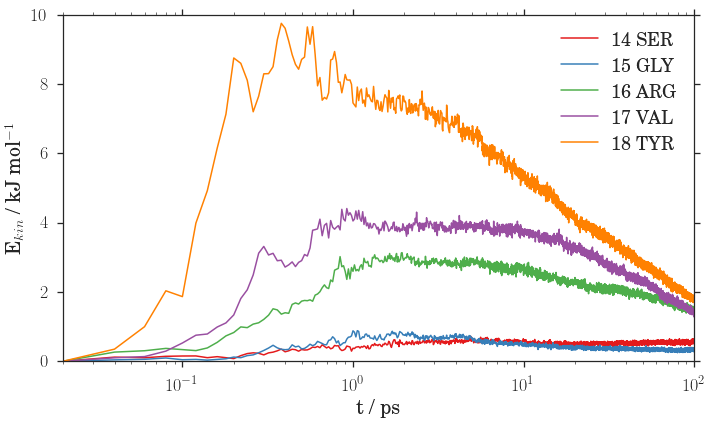

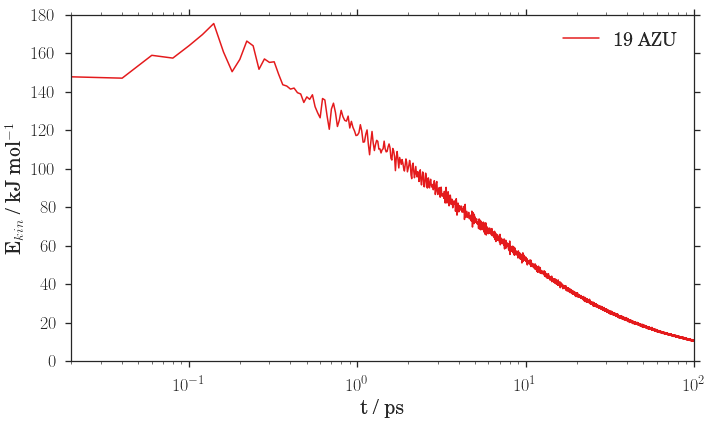

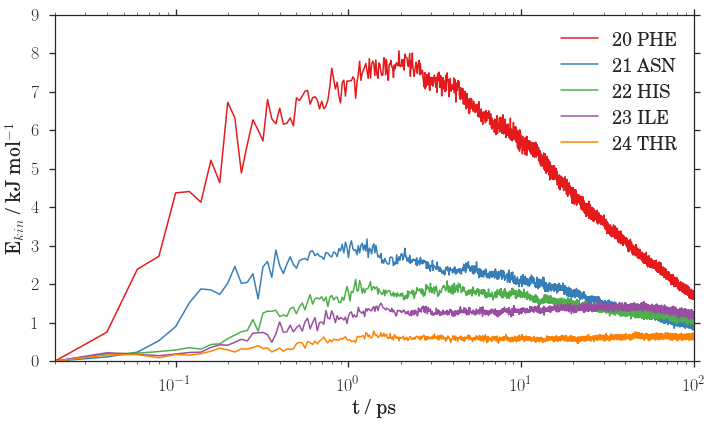

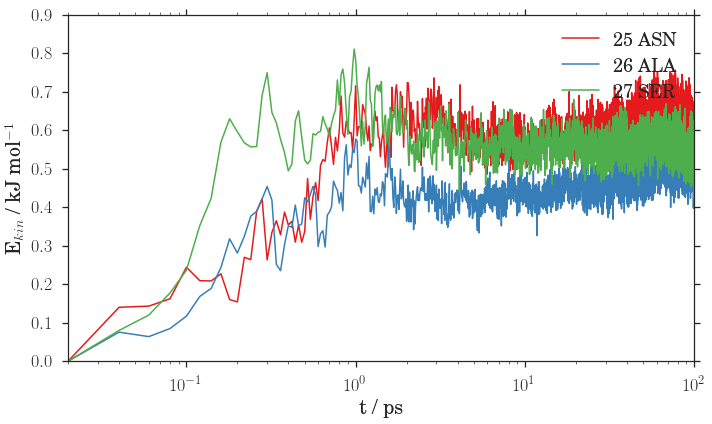

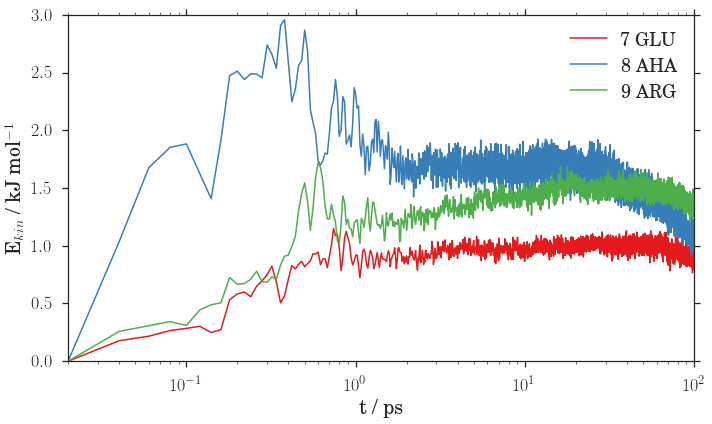

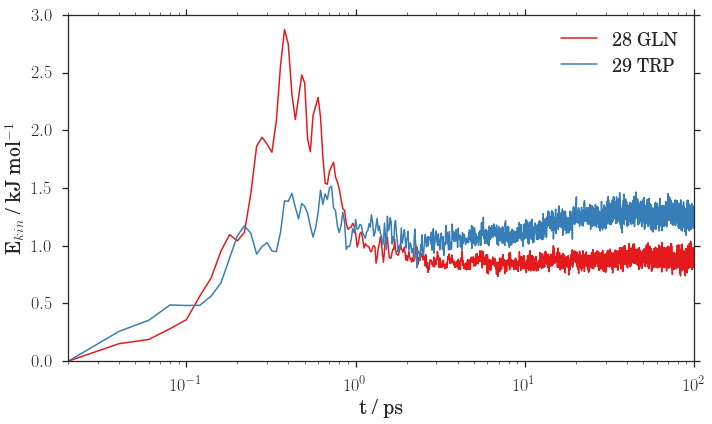

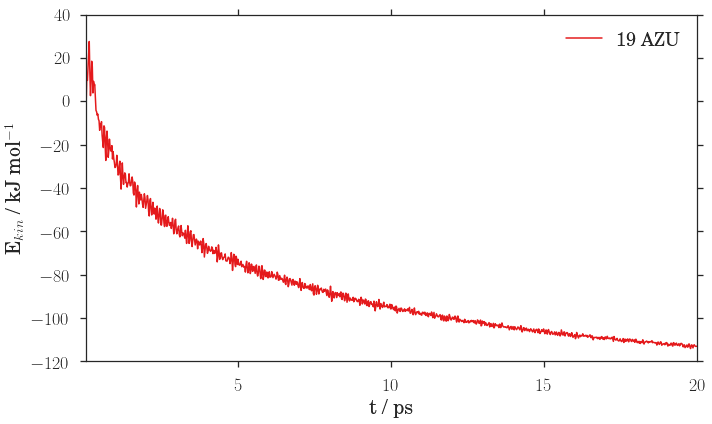

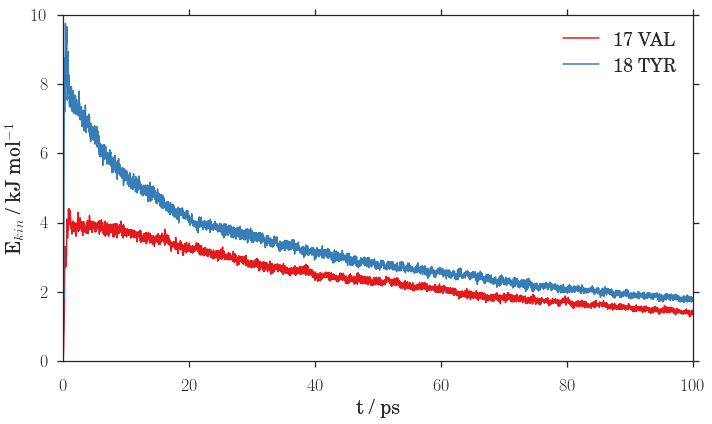

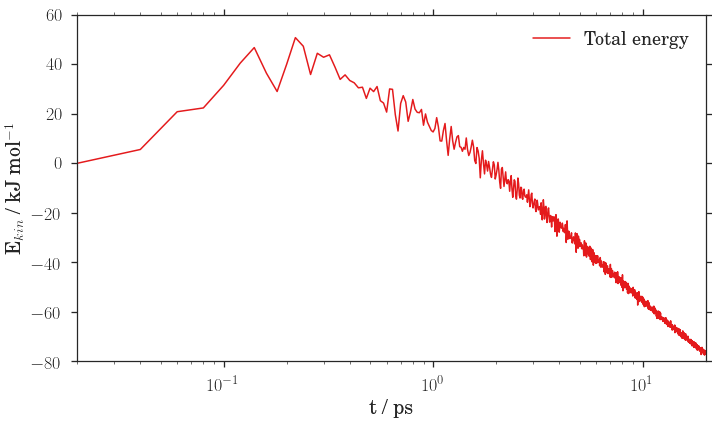

In [4]:
E_kin_MD = np.load('../working_files/E_kin_all_residues_average.npy')/100 # divide by 100 due to MDanalysis units
t = np.load('../working_files/time_scale.npy')
time_MD = t

# apply savitzki golay filter to data
'''exponential_intervals = [0]
exponential_intervals += [10**i for i in range(1, int(round(np.log10(len(E_kin_MD[0])))))]

for ekin in E_kin_MD:
    for i in range(len(exponential_intervals)-1):
        if i < len(exponential_intervals)-2:
            index1 = exponential_intervals[i]
            index2 = exponential_intervals[i+1]
            ekin_unfiltered = ekin[index1:index2]
            ekin_filtered = sig.savgol_filter(ekin_unfiltered, 5**(i+1), 4)
            ekin[index1:index2] = ekin_filtered
            
        elif i == len(exponential_intervals)-2:
            index1 = exponential_intervals[i]
            ekin_unfiltered = ekin[index1:]
            ekin_filtered = sig.savgol_filter(ekin_unfiltered, 5**(i+1), 4)
            ekin[index1:] = ekin_filtered'''


plotlabels = residue_names[1:]

    
plot_E_kin(E_kin_MD[12:17], t, plotlabels[12:17])

plot_E_kin(E_kin_MD[17:18], t, plotlabels[17:18], norm_to_zero=False)

plot_E_kin(E_kin_MD[18:23], t, plotlabels[18:23])

plot_E_kin(E_kin_MD[23:26], t, plotlabels[23:26])


plot_E_kin(E_kin_MD[5:8], t, plotlabels[5:8])

plot_E_kin(E_kin_MD[26:], t, plotlabels[26:])

plot_E_kin(E_kin_MD[17:18, :1000], t[:1000], plotlabels[17:18], log=False)
plot_E_kin(E_kin_MD[15:17], t, plotlabels[15:17], log=False)


# total energy of peptide
plot_E_kin([np.sum(E_kin_MD, axis=0)[:1000]], time_MD[:1000], plotlabels=['Total energy'], saveroot='E_kin_tot_MD')

## Exponential fit of the decay rate of the heater

5001 5001 0.219999995083 40.0199991055
Beta: [ 112.98741796  -10.31209822   20.94785536   -2.26781071]
Beta Std Error: [  6.77035280e+05   5.62114857e-02   7.16247572e-02   6.17914263e+04]
Beta Covariance: [[  6.90489422e+11   5.14728859e+03  -2.28953749e+03  -6.30193543e+10]
 [  5.14728859e+03   4.75975455e-03   5.14602982e-03  -4.69777024e+02]
 [ -2.28953749e+03   5.14602982e-03   7.72788685e-03   2.08963825e+02]
 [ -6.30193543e+10  -4.69777024e+02   2.08963825e+02   5.75162905e+09]]
Residual Variance: 0.6638432916367862
Inverse Condition #: 4.171801447817732e-10
Reason(s) for Halting:
  Sum of squares convergence
[ 112.98741796  -10.31209822   20.94785536   -2.26781071]


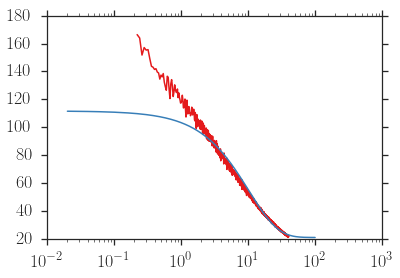

In [5]:
# fit the decay rate of azu to the data
def exp_func(B, x):
    return func.ExponentialC(x, *B)

def f(B, x):
    '''Linear function y = m*x + b'''
    return B[0]*x + B[1]

#exponential fit
exp_model = odr.Model(exp_func)
print(len(t), len(E_kin_MD[17:18][0]), t[10], t[2000])
azu_data = odr.Data(t[10:2000], E_kin_MD[17:18, 10:2000][0])
azu_odr = odr.ODR(azu_data, exp_model, beta0=[160, -10, 0.21, 0])

azu_fit_results = azu_odr.run()

azu_fit_results.pprint()
popt = azu_fit_results.beta
print(popt)

fig =  plt.figure()
axe = fig.add_subplot(111)

axe.plot(t[10:2000], E_kin_MD[17:18, 10:2000][0])
axe.plot(t, exp_func(popt,t))
axe.set_xscale('log')

#linear fit of logged data
lin_model = odr.Model(f)
#azu_data_ln = 

# Comparison of MD and MEQ

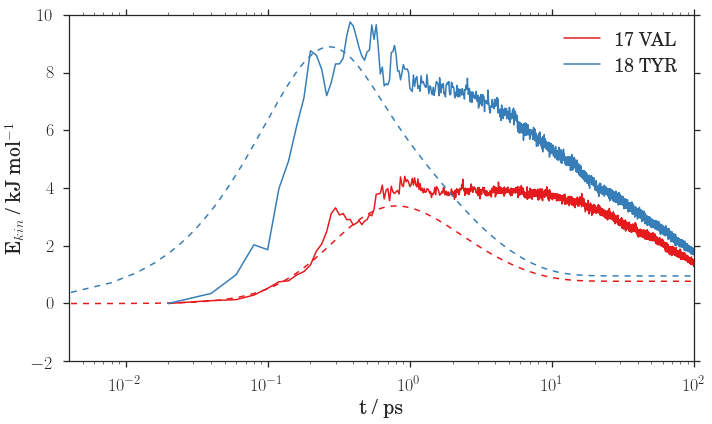

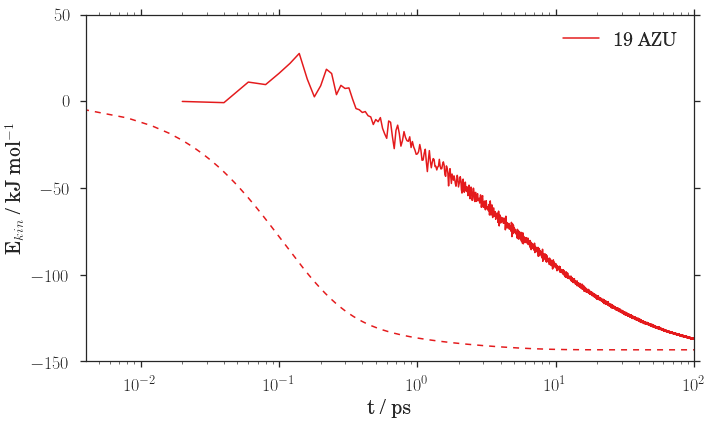

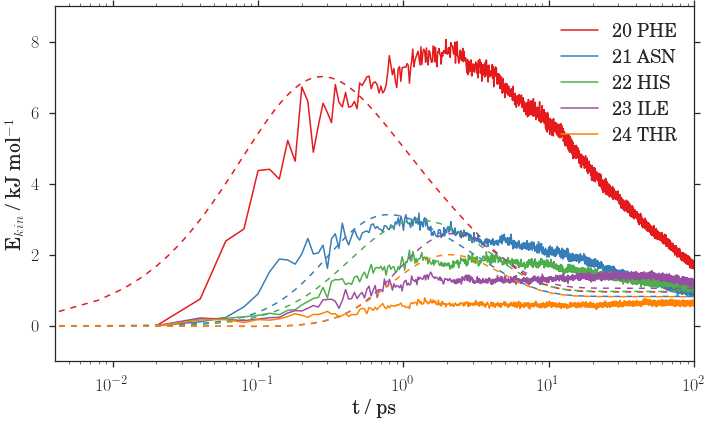

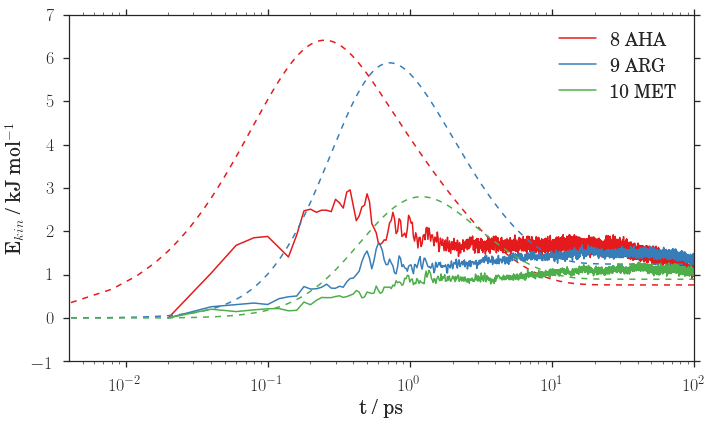

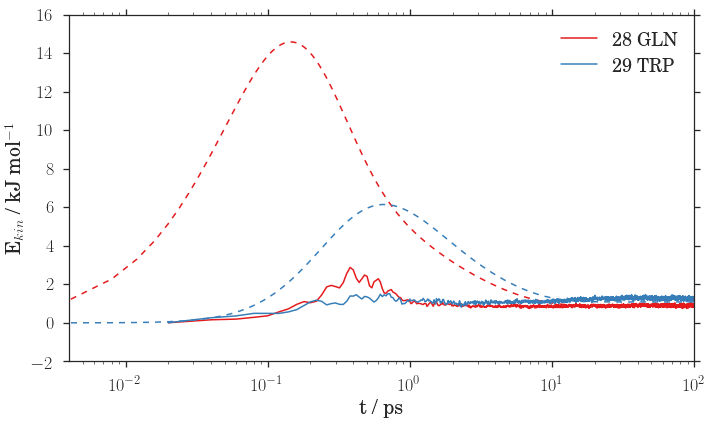

In [6]:
E_kin_MEQ = np.load('../working_files/E_kin_all_residues_MEQ.npy')/100
time_MEQ = np.linspace(0, 25000*4e-15, 25000)*1e12

plot_E_kin(E_kin_MD[15:17], time_MD, plotlabels[15:17], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_MEQ[16:18], t_model=time_MEQ)
plot_E_kin(E_kin_MD[17:18], time_MD, plotlabels[17:18], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_MEQ[18:19], t_model=time_MEQ)
plot_E_kin(E_kin_MD[18:23], time_MD, plotlabels[18:23], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_MEQ[19:24], t_model=time_MEQ)
plot_E_kin(E_kin_MD[6:9], time_MD, plotlabels[6:9], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_MEQ[7:10], t_model=time_MEQ)
plot_E_kin(E_kin_MD[26:], time_MD, plotlabels[26:], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_MEQ[27:29], t_model=time_MEQ)


# MEQ with excited limbo state
Trying to model the behaviour of the excited modes of AZU which will first have to decay vibronically to lower states for vibrational energy transport to happen. The initial distribution of the total kinetic energy of the heater between the limbostate * and the AZU residuum will be parametrized by the factor $\alpha$.
\begin{align*}
E_*^{init} &= \alpha \cdot E_{heat}^{init} \\ 
E_{AZU}^{init} &= (1-\alpha)\cdot E_{heat}^{init}
\end{align*}

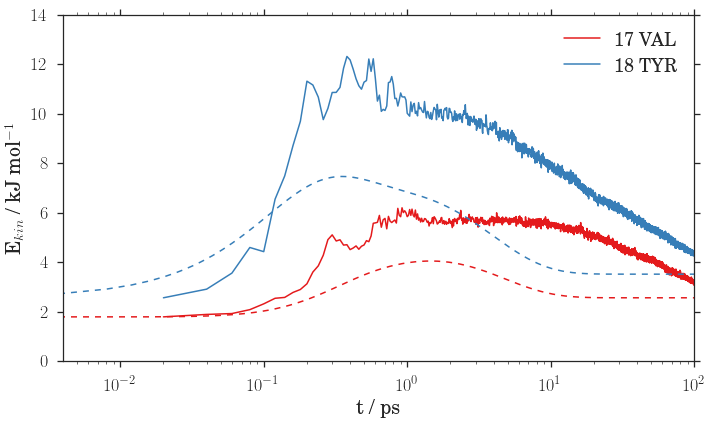

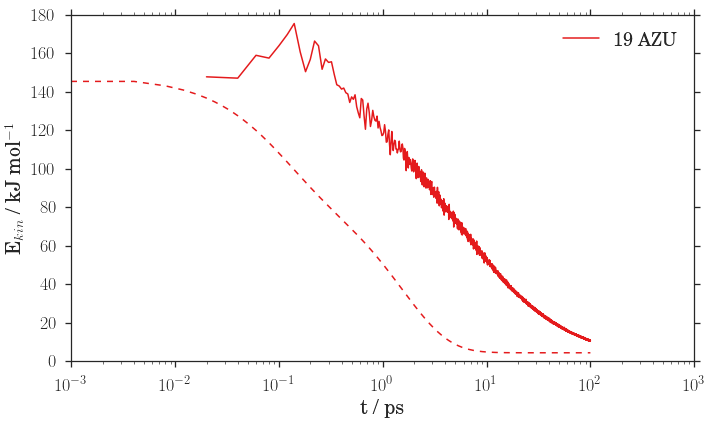

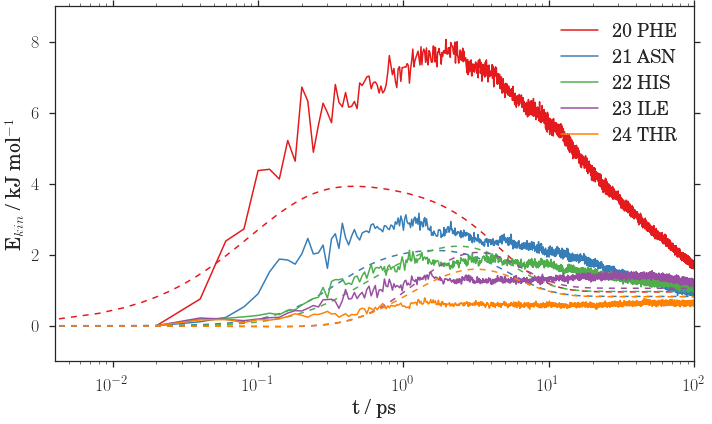

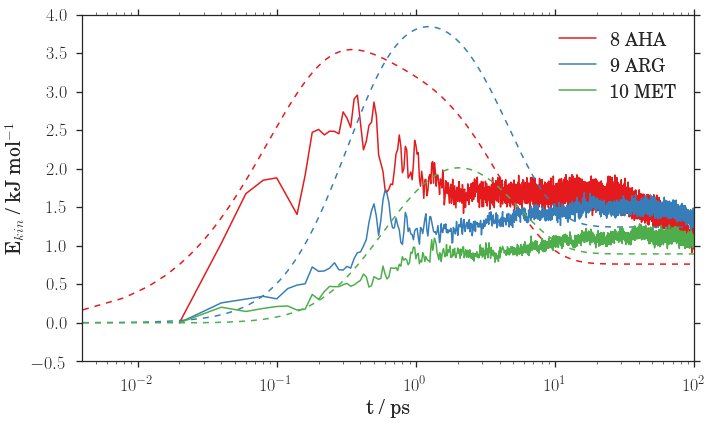

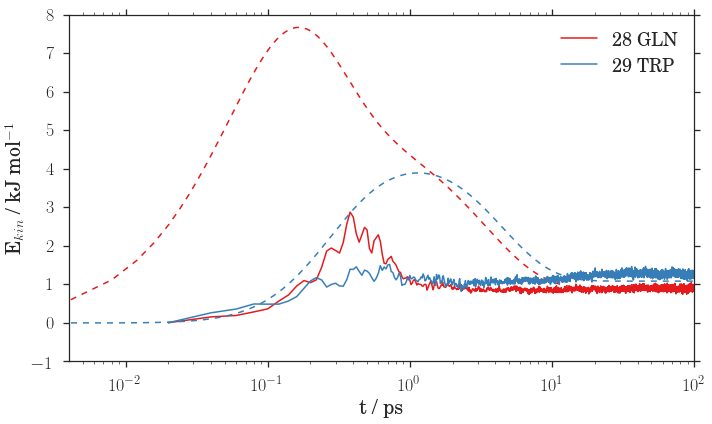

In [47]:
# import data from earlier MEQ runs
E_kin_init = E_kin_MEQ[:,0]
transition_rate_matrix = np.load("../working_files/910K/transition_rates_matrix.npy")

# create energy vector for a system that is expanded by the limbo state
alpha = 0.5
E_kin_init_limbo = np.array(E_kin_init.tolist()+[0])
E_kin_init_limbo[-1] = alpha * E_kin_init[18]
E_kin_init_limbo[18] = (1-alpha) * E_kin_init[18]
E_kin_AZU = 67/2 * k_B * 10 /1000 *mol # thermal energy of azu assuming 67dof and 10K in kJ/mol

#print(E_kin_init_limbo)

# create transition rate matrix for expanded system
transition_rate_matrix_limbo = np.zeros((len(transition_rate_matrix)+1, len(transition_rate_matrix)+1))

for i,j in itertools.combinations_with_replacement(range(len(transition_rate_matrix)), 2):
    transition_rate_matrix_limbo[i,j] = transition_rate_matrix[i,j]
    transition_rate_matrix_limbo[j,i] = transition_rate_matrix[j,i]
    
limbo_index = len(transition_rate_matrix_limbo)-1
transition_rate_matrix_limbo[18, limbo_index] = limbo_rate
transition_rate_matrix_limbo[limbo_index, limbo_index] = -limbo_rate

transition_rate_matrix_limbo = np.matrix(transition_rate_matrix_limbo)

# run MEQ simulation
n_steps = 25000
dt = 4e-15

trm_dt = transition_rate_matrix_limbo * dt # scaled transition rate matrix

E_kin_evolution_limbo = np.matrix(np.zeros((len(E_kin_init_limbo), n_steps)))
E_kin_evolution_limbo[:,0] = np.matrix(E_kin_init_limbo).T

for i in range(n_steps-1):
    E_kin_evolution_limbo[:,i+1] = E_kin_evolution_limbo[:,i] + (trm_dt * E_kin_evolution_limbo[:,i])

E_kin_evolution_limbo = np.array(E_kin_evolution_limbo)

E_kin_AZU_limbo = E_kin_evolution_limbo[18] + E_kin_evolution_limbo[-1]

plot_E_kin(E_kin_MD[15:17], time_MD, plotlabels[15:17], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_evolution_limbo[16:18], t_model=time_MEQ, norm_to_zero=False)
plot_E_kin(E_kin_MD[17:18], time_MD, plotlabels[17:18], saveroot='E_kin_MEQ_MD', E_kin_model=[E_kin_AZU_limbo], t_model=time_MEQ, norm_to_zero=False)
plot_E_kin(E_kin_MD[18:23], time_MD, plotlabels[18:23], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_evolution_limbo[19:24], t_model=time_MEQ)
plot_E_kin(E_kin_MD[6:9], time_MD, plotlabels[6:9], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_evolution_limbo[7:10], t_model=time_MEQ)
plot_E_kin(E_kin_MD[26:], time_MD, plotlabels[26:], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_evolution_limbo[27:29], t_model=time_MEQ)


# Preparation of data for backtracing fit

In [75]:
class AnalyticError(Exception):
    pass

# energies of md run
try:
    with open('../working_files/BacktracingData/MD_kinetic_energies.txt', 'w+') as f:
        f.write('time / ps \t')

        if len(residue_names) != len(E_kin_MD):
            raise AnalyticError('Not all trajectories are evaluated yet!')

        for resname in residue_names:
            f.write('E({0}) / kJ/mol \t'.format(resname.replace(' ', '')))
        f.write('\n')

        for i in range(len(time_MD)):
            f.write('{0} \t'.format(time_MD[i]))

            for n in range(len(E_kin_MD)):
                f.write('{0} \t'.format(E_kin_MD[n, i]))

            f.write('\n')
            
except Exception as e:
    print(e)
        
# mean distances along backbone
distances = np.loadtxt('../working_files/distance.txt', usecols=(2,))

with open('../working_files/BacktracingData/backbone_mean_dist.txt', 'w+') as f:
    f.write('Mean distances along backbone / nm \n')
    for d in distances:
        f.write('{0} \n'.format(d))
        
# tertiary contacts and corresponding variances
tert_con = np.loadtxt('../working_files/tert_cont_var.txt')

with open ('../working_files/BacktracingData/tertiary_cont_variances.txt', 'w+') as f:
    f.write('i \t j \t sigma_ij \ nm^2 \n')
    
    for t in tert_con:
        f.write('{0} \t {1} \t {2} \n'.format(int(t[0]+1), int(t[1]+1), t[2]))

Not all trajectories are evaluated yet!


# Transition matrices

In [ ]:
polar_rates_matrix = np.load('../working_files/polar_rates_matrix.npy')
axis = np.arange(1,37, 5)

def plot_matrix(matrix, xticklabels, yticklabels):
    fig = plt.figure(figsize=(10,10))
    axe = fig.add_subplot(111, aspect=1.0)

    mappable = axe.imshow(matrix, extent = [min(xticklabels), max(xticklabels), max(yticklabels), min(yticklabels)], cmap = sns.cubehelix_palette(light=1, as_cmap=True), interpolation='none')
    
    axe.xaxis.tick_top()
    axe.yaxis.tick_left()
    
    divider = make_axes_locatable(axe)
    cax = divider.append_axes("right", size="5%", pad=0.5)

    plt.colorbar(mappable, cax=cax)
    
    return fig
    
    
print(polar_rates_matrix[8,17], polar_rates_matrix[8,18], polar_rates_matrix[8,19])
print(polar_rates_matrix[27,:])
    
fig = plot_matrix(polar_rates_matrix, xticklabels=axis, yticklabels=axis)
fig.savefig('../Plots/polar_rates_matrix.png')

In [ ]:
bonded_rates_matrix = np.load('../working_files/bonded_rates_matrix.npy')
axis = np.arange(1,35)

polar_rates_matrix = np.load('../working_files/polar_rates_matrix.npy')
axis = np.arange(1,36, 5)
  
fig = plot_matrix(bonded_rates_matrix, xticklabels=axis, yticklabels=axis)
fig.savefig('../Plots/bonded_rates_matrix.pdf')

bonded_rates_matrix[27, 28]

# Represenation of transition rates

{1: [1, -0.36124166618715292], 2: [2, -0.67369564364655721], 3: [3, -0.89516329135506234], 4: [4, -0.99573417629503447], 5: [5, -0.96182564317281904], 6: [6, -0.7980172272802396], 7: [7, -0.52643216287735572], 8: [8, -0.18374951781657037], 9: [9, 0.18374951781657012], 10: [10, 0.52643216287735584], 11: [11, 0.79801722728023949], 12: [12, 0.96182564317281904], 13: [13, 0.99573417629503458], 14: [14, 0.89516329135506223], 15: [15, 0.6736956436465571], 16: [16, 0.36124166618715303], 17: [17, 2.4492935982947064e-16], 18: [18, -0.36124166618715259], 19: [19, -0.67369564364655743], 20: [20, -0.89516329135506234], 21: [21, -0.99573417629503447], 22: [22, -0.96182564317281916], 23: [23, -0.79801722728023916], 24: [24, -0.52643216287735628], 25: [25, -0.18374951781657017], 26: [26, 0.18374951781656945], 27: [27, 0.52643216287735561], 28: [28, 0.79801722728023983], 29: [29, 0.96182564317281893], 30: [30, 0.99573417629503447], 31: [31, 0.89516329135506267], 32: [32, 0.67369564364655732], 33: [33,

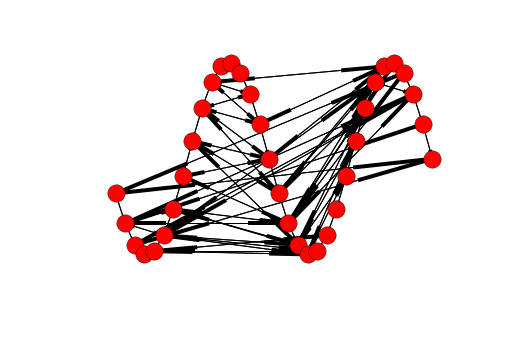

In [129]:
G=nx.DiGraph()
G.add_nodes_from([i for i in range(1,35)])

T = 2*np.pi*4/2/34

pos = {}
for i in range(1, 35):
    pos[i] = [i, -np.sin(T*i)] 

for i, j in itertools.combinations(range(34),2):
    if transition_rate_matrix[i,j] != 0:
        G.add_edge(i+1,j+1, weight = transition_rate_matrix[i,j])
        G.add_edge(j+1,i+1, weight = transition_rate_matrix[j,i])

print(pos)

nx.draw(G, pos, width=1.0)